In [70]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [72]:
len(words)

32033

In [73]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(len(itos))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [74]:
block_size = 3
def build_dataset(words):
    X, Y = [],[]

    for w in words:
    #     print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context),'---->',itos[ix])
            context = context[1:] + [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [54]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [56]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
#     emb = C[Xb]
#     embcat = emb.view(emb.shape[0], -1)
#     bmeani = hpreact.mean(0, keepdims=True)
#     bstdi = hpreact.std(1, keepdim=True)
#     hpreact = embcat @ W1 + b1
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
    
#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001*bmeani
#         bnstd_running = 0.999 * bnstd_running + 0.001*bstdi
    
#     h = torch.tanh(hpreact)
#     logits = h @ W2 + b2
#     loss = F.cross_entropy(logits, Yb)

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / (bnstdi)) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001*bmeani
        bnstd_running = 0.999 * bnstd_running + 0.001*bstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 2.2236


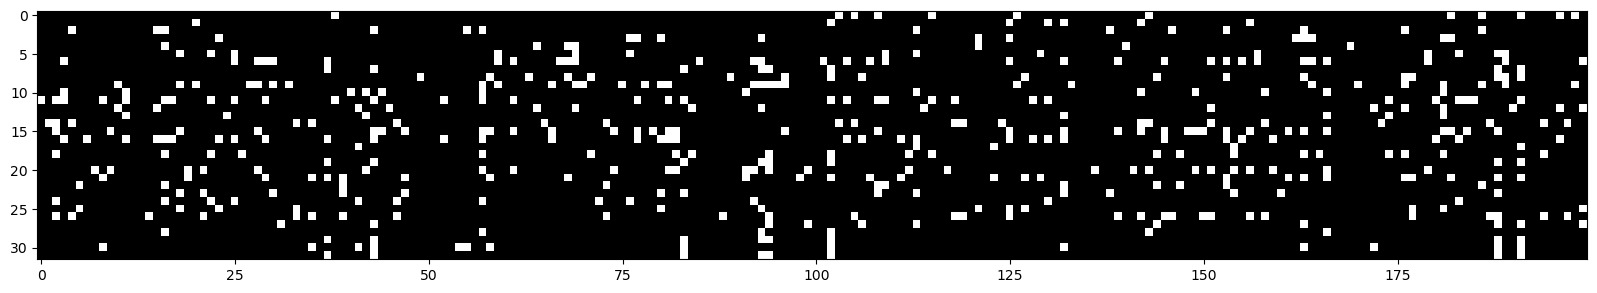

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation = 'nearest')

(array([573., 296., 207., 164., 131., 139., 103., 108., 108.,  90., 106.,
         69.,  56.,  75.,  82.,  71.,  71.,  77.,  76.,  87.,  72.,  68.,
         59.,  55.,  69.,  82.,  72.,  62.,  64.,  70.,  67.,  69.,  66.,
         78.,  95.,  89.,  75.,  95.,  75., 110.,  97.,  92., 112., 117.,
        145., 148., 210., 246., 340., 712.]),
 array([-9.99978721e-01, -9.59980367e-01, -9.19982014e-01, -8.79983660e-01,
        -8.39985306e-01, -7.99986953e-01, -7.59988599e-01, -7.19990245e-01,
        -6.79991891e-01, -6.39993538e-01, -5.99995184e-01, -5.59996830e-01,
        -5.19998477e-01, -4.80000123e-01, -4.40001769e-01, -4.00003415e-01,
        -3.60005062e-01, -3.20006708e-01, -2.80008354e-01, -2.40010000e-01,
        -2.00011647e-01, -1.60013293e-01, -1.20014939e-01, -8.00165856e-02,
        -4.00182319e-02, -1.98781490e-05,  3.99784756e-02,  7.99768293e-02,
         1.19975183e-01,  1.59973537e-01,  1.99971890e-01,  2.39970244e-01,
         2.79968598e-01,  3.19966952e-01,  3.59965

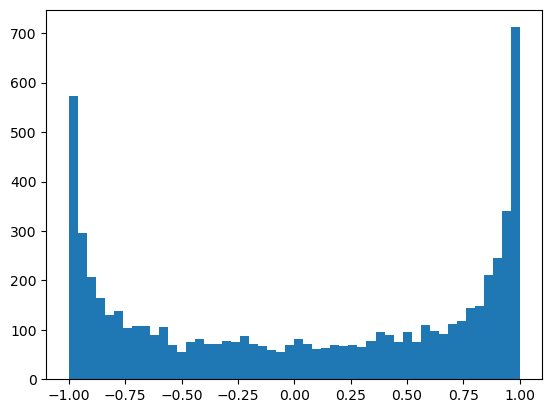

In [43]:
plt.hist(h.view(-1).tolist(), 50)

In [12]:
loss.item()

NameError: name 'loss' is not defined

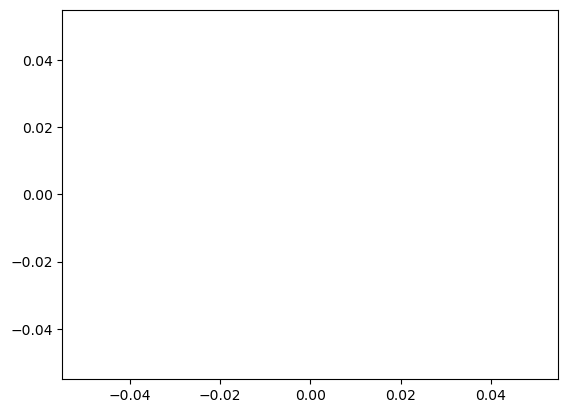

In [13]:
plt.plot(lossi)

In [13]:
@torch.no_grad()
def split_loss(split):
    X, Y ={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact)
    logits =  h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())
    
split_loss('val')
split_loss('test')

val 2.1684703826904297
test 2.1600069999694824


In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.


In [88]:
#pytorch implementation

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [89]:
#Deeper Network

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

Layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    Layers[-1].gamma *= 0.1
    
    for layer in Layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3
            
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [90]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in Layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in Layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()
    
     #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2870
